In [1]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets
# Convert categorical target labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Display the split data
print("Training features:\n", X_train)
print("Testing features:\n", X_test)
print("Training labels:\n", y_train)
print("Testing labels:\n", y_test)

# Initialize the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))

c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training features:
      radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
68     9.029     17.33       58.79   250.5      0.10660       0.14130   
181   21.090     26.57      142.70  1311.0      0.11410       0.28320   
63     9.173     13.86       59.20   260.9      0.07721       0.08751   
248   10.650     25.22       68.01   347.0      0.09657       0.07234   
60    10.170     14.88       64.55   311.9      0.11340       0.08061   
..       ...       ...         ...     ...          ...           ...   
71     8.888     14.64       58.79   244.0      0.09783       0.15310   
106   11.640     18.33       75.17   412.5      0.11420       0.10170   
270   14.290     16.82       90.30   632.6      0.06429       0.02675   
435   13.980     19.62       91.12   599.5      0.10600       0.11330   
102   12.180     20.52       77.22   458.7      0.08013       0.04038   

     concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
68      0.31300       

Top 10 Features and their SHAP values:
symmetry2: 0.36409977078437805
texture1: 0.41998159885406494
symmetry3: 0.4206884205341339
compactness2: 0.5885229706764221
concavity3: 0.7823750972747803
area2: 0.7873820066452026
texture3: 0.84684157371521
concave_points3: 0.9759284853935242
area3: 1.1770294904708862
concave_points1: 1.2518067359924316


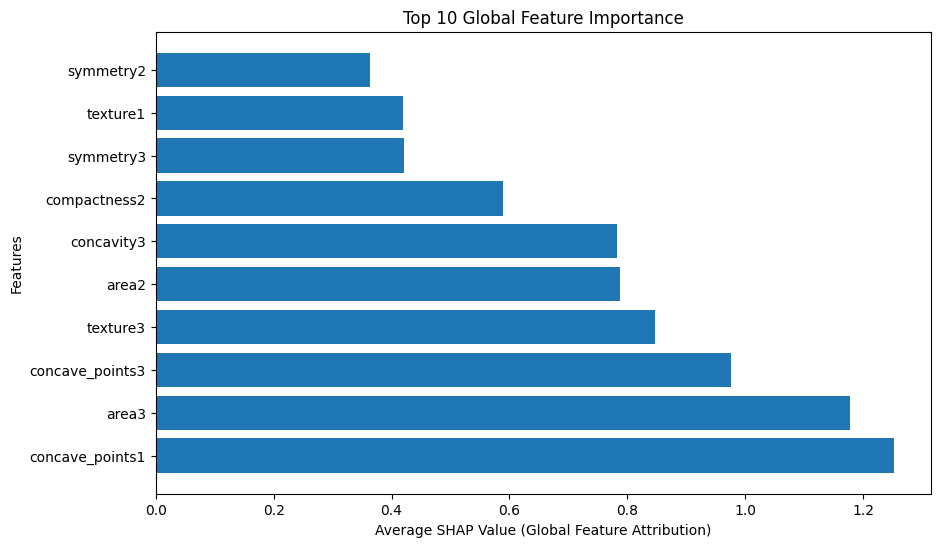

In [2]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Use SHAP's TreeExplainer to explain the XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Calculate global importance for each feature (take the mean of the absolute SHAP values)
global_shap_importance = np.abs(shap_values).mean(axis=0)

# Sort feature importance by magnitude and select the top 10 most important features
top_10_features = np.argsort(global_shap_importance)[-10:]

# Print the top 10 features and their SHAP values
print("Top 10 Features and their SHAP values:")
for feature, value in zip(X_test.columns[top_10_features], global_shap_importance[top_10_features]):
    print(f"{feature}: {value}")

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_features)), global_shap_importance[top_10_features], align='center')
plt.yticks(range(len(top_10_features)), X_test.columns[top_10_features])  # Use feature names
plt.xlabel("Average SHAP Value (Global Feature Attribution)")
plt.ylabel("Features")
plt.title("Top 10 Global Feature Importance")
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.show()


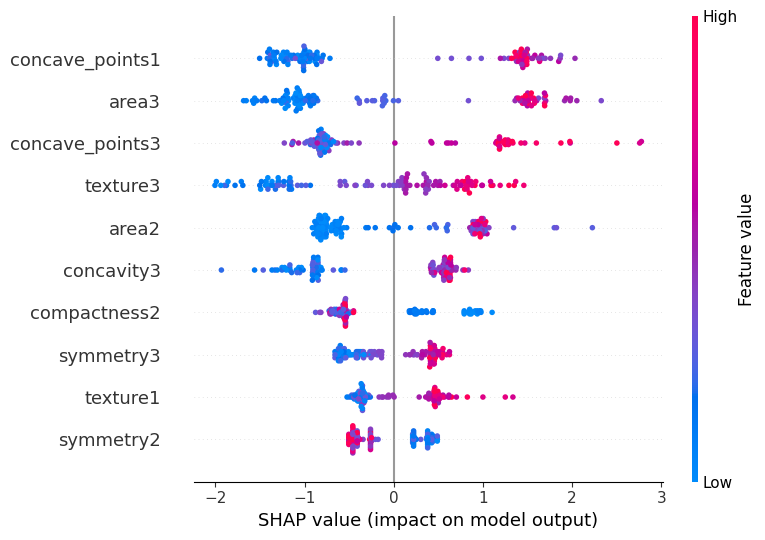

In [3]:
# Generate a beeswarm plot using SHAP's summary_plot function (showing only the top 10 features)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)


Confusion Matrix:
 [[69  2]
 [ 3 40]]
True Positive (most confident): 50
True Negative (most confident): 112
False Positive (most confident): 108
False Negative (most confident): 20


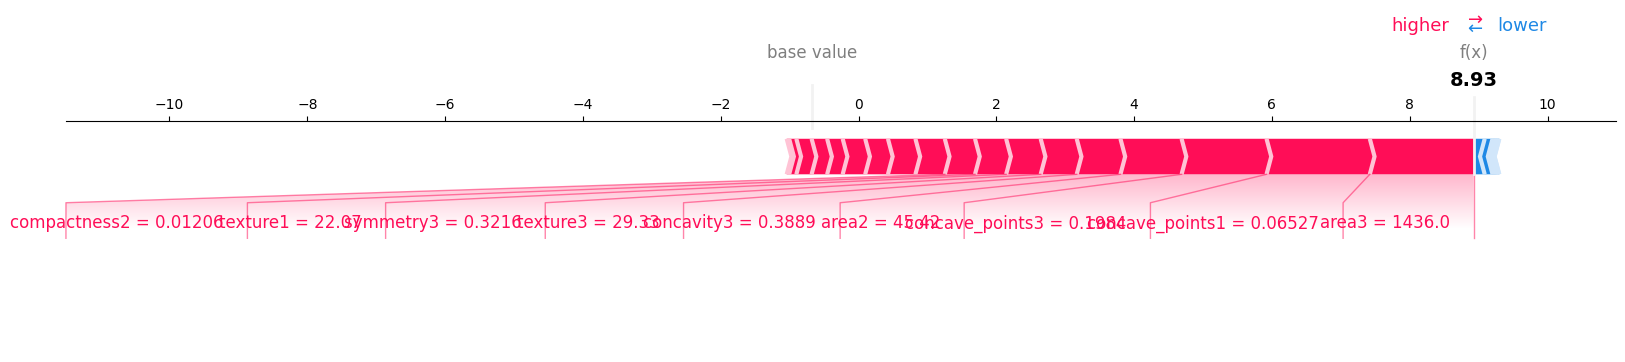

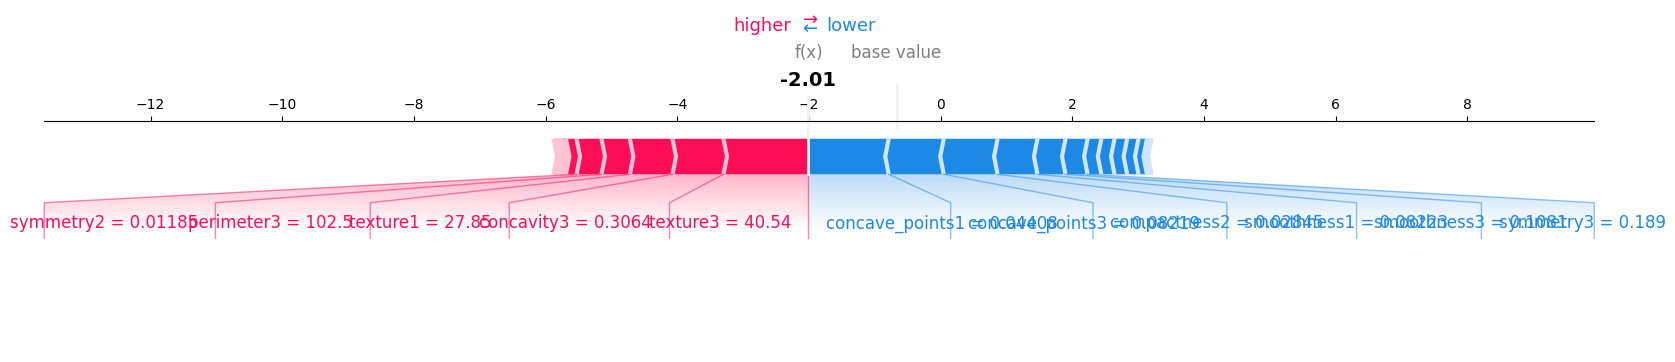

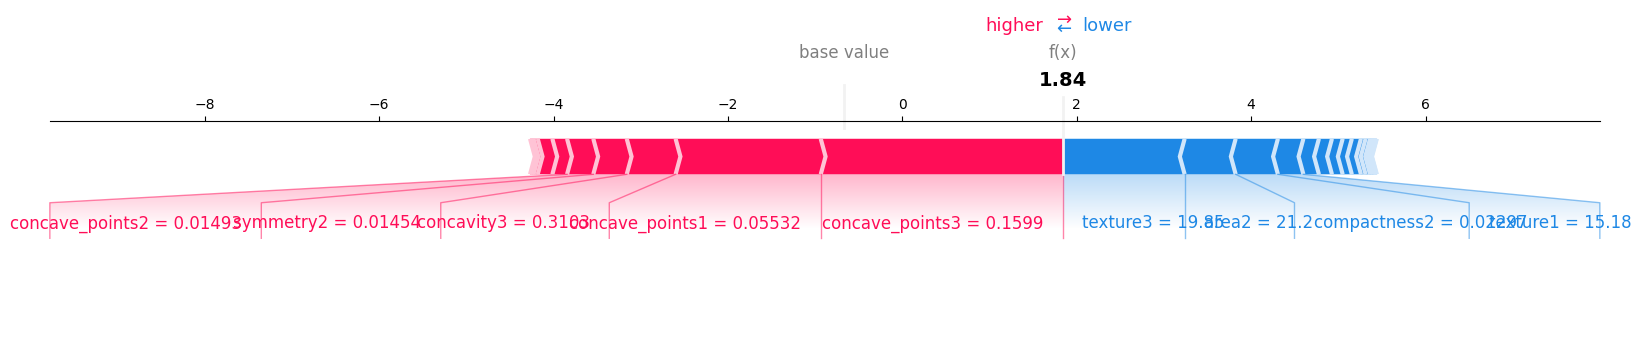

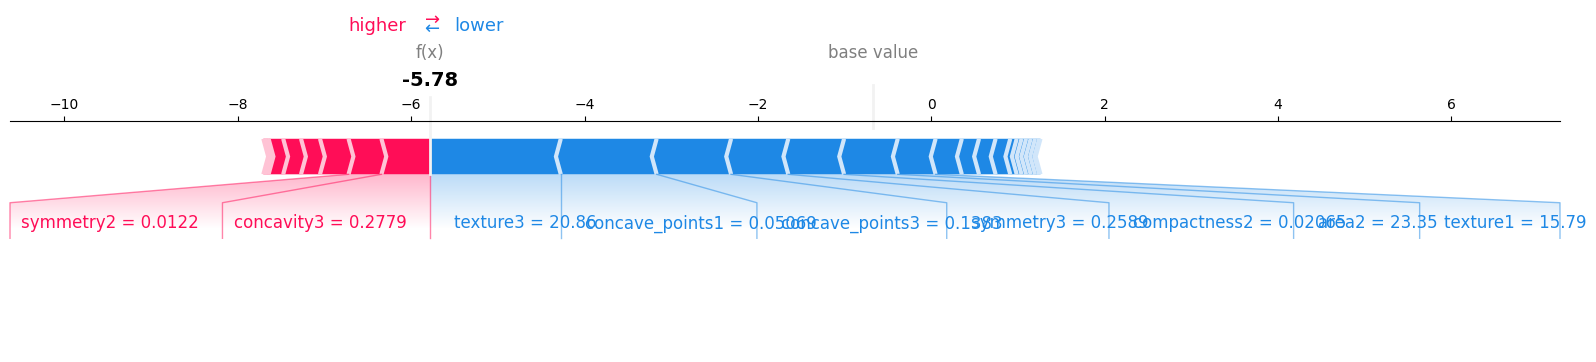

In [6]:
from sklearn.metrics import confusion_matrix

# Get predicted probabilities (use the predict_proba function to get probabilities)
y_proba = model.predict_proba(X_test)

# Get predicted labels
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Output the confusion matrix
print("Confusion Matrix:\n", cm)

# Get the indices of true positives, true negatives, false positives, and false negatives
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

# Select the most confident and least confident samples
# (a) The sample with the highest probability in true positives
most_confident_true_positive = true_positive_indices[np.argmax(y_proba[true_positive_indices][:, 1])]
# (b) The sample with the lowest probability in true negatives
most_confident_true_negative = true_negative_indices[np.argmin(y_proba[true_negative_indices][:, 0])]
# (c) The sample with the highest probability in false positives
most_confident_false_positive = false_positive_indices[np.argmax(y_proba[false_positive_indices][:, 1])]
# (d) The sample with the lowest probability in false negatives
most_confident_false_negative = false_negative_indices[np.argmin(y_proba[false_negative_indices][:, 1])]

# Check the selected sample indices
print("True Positive (most confident):", most_confident_true_positive)
print("True Negative (most confident):", most_confident_true_negative)
print("False Positive (most confident):", most_confident_false_positive)
print("False Negative (most confident):", most_confident_false_negative)

# Use SHAP TreeExplainer to calculate SHAP values
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the most and least confident samples
shap_values_true_positive = explainer.shap_values(X_test.iloc[[most_confident_true_positive]])
shap_values_true_negative = explainer.shap_values(X_test.iloc[[most_confident_true_negative]])
shap_values_false_positive = explainer.shap_values(X_test.iloc[[most_confident_false_positive]])
shap_values_false_negative = explainer.shap_values(X_test.iloc[[most_confident_false_negative]])

# (a) Force plot for true positive
shap.force_plot(explainer.expected_value, shap_values_true_positive, X_test.iloc[[most_confident_true_positive]], matplotlib=True)

# (b) Force plot for true negative
shap.force_plot(explainer.expected_value, shap_values_true_negative, X_test.iloc[[most_confident_true_negative]], matplotlib=True)

# (c) Force plot for false positive
shap.force_plot(explainer.expected_value, shap_values_false_positive, X_test.iloc[[most_confident_false_positive]], matplotlib=True)

# (d) Force plot for false negative
shap.force_plot(explainer.expected_value, shap_values_false_negative, X_test.iloc[[most_confident_false_negative]], matplotlib=True)
